# Head Pose Estimation

- Our goal in this project to predict head pose estimation with 3 axes (Pitch, Yaw, Roll) face geometry using [AFLW2000 Dataset](http://cvlab.cse.msu.edu/lfw-and-aflw2000-datasets.html) by using 3 Regression models.
- This Dataset includes 2000 images contain faces so we use *mediapipe* library to extact face points as features(468 points (x,y)) so we have 468 * 2 so final features count  = 936.
- Then extract labels from matlab file that related to each image we have three labels as output the 3 axes (Pitch, Yaw, Roll) values.
- We will use MediaPipe library in both training and testing phases:
  - In Training: first we dtect the face of each image then using the same library to generate the landmark points of the face after this phase the training data (features) will contain 1853 samples with 936 columns (468 for X and 468 for Y), for labels we will extract the 3 angels from the mat file. 
  - In Testing: we will use the MediaPipe Library to generate the landmarks as we did in the training phase and using the trained models to predict the 3 labels and using them to draw the axis.  
### So, Let's Start 😃 
### The Office fans will enjoy some of this project 😎

## Import needed Libraries

In [1]:
import os
import cv2
import glob
import warnings
import mediapipe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
from math import cos, sin

%matplotlib inline
warnings.filterwarnings('ignore')

## Define Helper Functions

In [2]:
def get_pyr_from_mat(mat_path):
    '''Get yaw, pitch, roll from .mat annotation.
    [pitch yaw roll tdx tdy tdz scale_factor]
    return [pitch, yaw, roll]'''
    
    mat = sio.loadmat(mat_path)
    pre_pose_params = mat['Pose_Para'][0]
    pose_params = pre_pose_params[:3]
    
    return pose_params

In [3]:
def get_pt2d_from_img(img_name, relative_path = True, frame = False):
    '''this function get each point on the face x,y 468 * 2 to get 936 features per face.
    input: 
        - img_name: file name or image itself decided which using the next inputs as default is image name with relative path
        - relative_path: default value is True, if False it take the whole pass from the user
        - frame: override the previous flag if Ture deals as image or frame from video
    output:
        - numpy array of tuple for each point on the face.'''
    
    x_points = []
    y_points = []
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
#         print(f'get_pt2d_from_img -- {frame}')
        if frame:
            image = img_name
        elif relative_path :
            image = cv2.imread('AFLW2000/'+img_name+'.jpg')
        else:
            image = cv2.imread(img_name)
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:

            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                x_points.append(relative_x)
                y_points.append(relative_y)
                
    return(np.array([x_points,y_points]))  

In [4]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size = 100):
    '''this function take image and return image with drawn pitch, yaw and roll axes on it.
    input: 
        - img: image itself,
        - pitch: pitch value to be drawn as axis,
        - yaw: yaw value to be drawn as axis,
        - roll: roll value to be drawn as axis,
        - tdx: point on x-axis draw axis from, if None it sclect point in the moddle of the image,
        - tdy: point on y-axis draw axis from, if None it sclect point in the moddle of the image,
        - size: the lenght of axis in pixles.
    output:
        - image with drawn pitch, yaw and roll axes on it.'''

    yaw = -yaw

    if tdx != None and tdy != None:
        pass

    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    
    
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    

    return img

## Read Data 

In [5]:
mylist = [Path(f).stem for f in glob.glob("AFLW2000/*.mat")]
random_number = 50
mylist[random_number]

'image00076'

In [6]:
len(get_pt2d_from_img(mylist[random_number])[0])


468

##  Data Extraction

In [8]:
# get_pt2d_from_img(mylist[3])

x_y_list = [x for x in zip(*get_pt2d_from_img(mylist[random_number]))]
get_pt2d_from_img(mylist[random_number])
x_y_list[:5]

[(242, 299), (253, 277), (244, 283), (243, 251), (254, 270)]

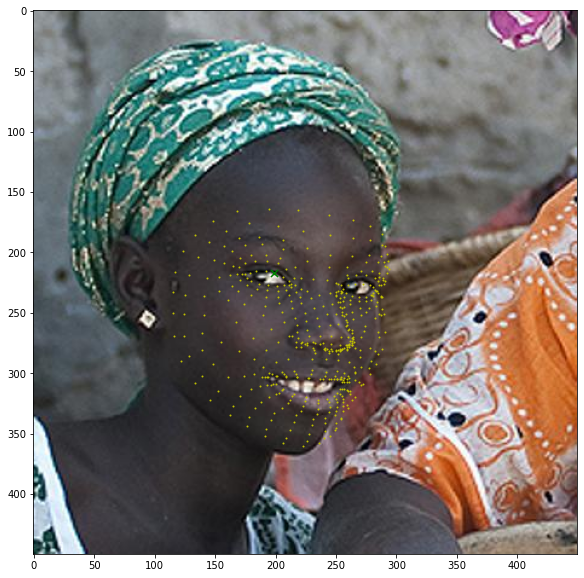

In [33]:
plt.figure(figsize=(10,10))

img = cv2.imread('AFLW2000/'+mylist[random_number]+'.jpg')

pitch, yaw, roll = get_pyr_from_mat('AFLW2000/'+mylist[random_number]+'.mat')

# img = draw_axis(img, pitch, yaw, roll, x_y_list[1][0], x_y_list[1][1])
plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for pt in x_y_list:
    plt.scatter(pt[0],pt[1],c = 'y',s = 1);
    
plt.scatter(x_y_list[158][0],x_y_list[158][1],c = 'green',s = 50, marker='x');
# plt.scatter(x_y_list[10][0],x_y_list[10][1],c = 'black',s = 50, marker='x');

plt.imshow(plt_img);


In [34]:
# plt.figure(figsize=(10,10))
# pitch, yaw, roll = get_ypr_from_mat(os.path.join('AFLW2000/',mylist[random_number]))
# fnl_img = draw_axis(img, pitch, yaw, roll, x_y_list[1][0], x_y_list[1][1])
# plt_fnl_img = cv2.cvtColor(fnl_img, cv2.COLOR_BGR2RGB)

# plt.imshow(plt_fnl_img)

## Data Prepration 

In [35]:
'''df = pd.DataFrame(columns=[['x'+str(i) for i in range(1, 469)] + ['y'+str(i) for i in range(1, 469)] + ['pitch', 'yaw', 'roll']])

for img_file in mylist:
    full_path = os.path.join('AFLW2000/', img_file)
    x_y_list = get_pt2d_from_img(img_file)
    
    xs = x_y_list[0]
    ys = x_y_list[1]
#     print(img_file)
#     print(len(xs))
    if len(xs):
        divisor = ys[10] - ys[1]
        xs = (xs - xs[1]) / divisor
        ys = (ys - ys[1]) / divisor
#     print(xs)
        pyr = get_pyr_from_mat(full_path)
    
        df = df.append(
            pd.DataFrame(
                np.append(xs, np.append(ys, pyr ,axis=0),axis=0).reshape(1,-1),
                columns=df.columns),
            ignore_index=True)
    else:
        continue
df.to_csv('Head_poses_data.csv')'''


"df = pd.DataFrame(columns=[['x'+str(i) for i in range(1, 469)] + ['y'+str(i) for i in range(1, 469)] + ['pitch', 'yaw', 'roll']])\n\nfor img_file in mylist:\n    full_path = os.path.join('AFLW2000/', img_file)\n    x_y_list = get_pt2d_from_img(img_file)\n    \n    xs = x_y_list[0]\n    ys = x_y_list[1]\n#     print(img_file)\n#     print(len(xs))\n    if len(xs):\n        divisor = ys[10] - ys[1]\n        xs = (xs - xs[1]) / divisor\n        ys = (ys - ys[1]) / divisor\n#     print(xs)\n        pyr = get_pyr_from_mat(full_path)\n    \n        df = df.append(\n            pd.DataFrame(\n                np.append(xs, np.append(ys, pyr ,axis=0),axis=0).reshape(1,-1),\n                columns=df.columns),\n            ignore_index=True)\n    else:\n        continue\ndf.to_csv('Head_poses_data.csv')"

In [9]:
df = pd.read_csv('Head_poses_data.csv', index_col=0)

In [10]:
#Drop the axises we subtracted from it and also zero value points
df =df.drop(['x2','y2'], axis = 1)
df.head(20)
df

,x1,x3,x4,x5,x6,x7,x8,x9,x10,x11,...,y462,y463,y464,y465,y466,y467,y468,pitch,yaw,roll
0,0.012987,-0.000000,0.032468,-0.000000,-0.012987,-0.038961,0.370130,-0.051948,-0.058442,-0.090909,...,-0.012987,-0.019481,0.448052,0.428571,0.402597,0.487013,0.512987,-0.399231,0.018227,0.085676
1,-0.120879,-0.153846,-0.098901,-0.000000,-0.054945,-0.230769,-0.230769,-0.285714,-0.274725,-0.351648,...,-0.043956,-0.065934,0.417582,0.395604,0.384615,0.450549,0.483516,0.470065,1.189533,0.300959
2,0.017241,0.017241,0.086207,-0.000000,-0.000000,0.034483,0.568966,0.051724,0.051724,0.068966,...,-0.017241,-0.017241,0.448276,0.431034,0.413793,0.500000,0.517241,-0.184650,0.881137,-0.236852
3,-0.121951,-0.073171,0.097561,0.032520,0.048780,0.065041,0.398374,0.121951,0.154472,0.227642,...,0.008130,0.008130,0.560976,0.528455,0.495935,0.723577,0.764228,-0.175379,0.299208,-0.373374
4,-0.064516,-0.024194,0.088710,0.016129,0.032258,0.064516,0.483871,0.088710,0.104839,0.169355,...,-0.016129,-0.032258,0.451613,0.427419,0.411290,0.556452,0.572581,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.060150,0.045113,0.067669,-0.007519,-0.000000,0.037594,0.578947,0.045113,0.037594,0.045113,...,-0.015038,-0.022556,0.436090,0.413534,0.398496,0.496241,0.511278,-0.306358,-0.283822,0.038554
1849,0.070922,0.049645,0.063830,-0.007092,-0.007092,0.028369,0.531915,0.028369,0.021277,0.007092,...,-0.021277,-0.021277,0.453901,0.425532,0.411348,0.496454,0.524823,-0.367547,-0.429723,0.122791
1850,0.074074,0.037037,-0.000000,-0.027778,-0.046296,-0.092593,0.398148,-0.138889,-0.175926,-0.259259,...,-0.046296,-0.064815,0.379630,0.370370,0.361111,0.333333,0.361111,-0.156035,0.567114,-0.108536
1851,0.025478,0.012739,0.031847,-0.006369,-0.012739,-0.038217,0.420382,-0.050955,-0.057325,-0.095541,...,-0.019108,-0.025478,0.420382,0.401274,0.382166,0.445860,0.464968,-0.197102,-0.070430,0.105118


## Spliting the data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
pca = PCA(10)

x = df.drop(['pitch', 'yaw', 'roll'], axis=1)
x = pca.fit_transform(x)
pitch = df['pitch']
yaw = df['yaw']
roll = df['roll']

pitch_X_train, pitch_X_test, pitch_y_train, pitch_y_test = train_test_split(x, pitch, test_size=0.2,random_state=42)

yaw_X_train, yaw_X_test, yaw_y_train, yaw_y_test = train_test_split(x, yaw, test_size=0.2,random_state=42)

roll_X_train, roll_X_test, roll_y_train, roll_y_test = train_test_split(x, roll, test_size=0.2,random_state=42)

## Scaling the data

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

pitch_xtrain_scaled = scaler.fit_transform(pitch_X_train)
pitch_xtest_scaled = scaler.transform(pitch_X_test)

yaw_xtrain_scaled = scaler.fit_transform(yaw_X_train)
yaw_xtest_scaled = scaler.transform(yaw_X_test)

roll_xtrain_scaled = scaler.fit_transform(roll_X_train)
roll_xtest_scaled = scaler.transform(roll_X_test)

## Import Needed Libraries for the model

In [13]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as MSE

## Train Models 

In [14]:
pitch_predictor = RandomForestRegressor()
# pitch_predictor = LinearRegression()
# pitch_predictor = GBR(learning_rate=0.1,n_estimators=50)

pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)

print('Training Scores\nR2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print('Testing Scores\nR2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

# random_number =2
# data,tdx,tdy,x_y_list = test_img('AFLW2000/'+mylist[random_number]+'.jpg')
# data = data.drop(['x2','y2'], axis = 1)
# data_scaled= pca.transform(data)
# print(pitch_predictor.predict(data_scaled))
# print(pitch_y_test[random_number])

Training Scores
R2-Score:  0.7922415059119354
RMSE : 0.27300869650475984
Testing Scores
R2-Score:  0.22344559110024165
RMSE : 0.2380755115079803


In [15]:
yaw_predictor = SVR(degree=3,C=10,)

yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

print('Training Scores\nR2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print('Testing Scores\nR2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.9565685171686594
RMSE : 0.12458995472414756
Testing Scores
R2-Score:  0.9013603364228978
RMSE : 0.1580101233368106


In [16]:
roll_predictor = SVR(degree=2,C=10,)

roll_predictor.fit(roll_xtrain_scaled, roll_y_train, )

print('Training Scores\nR2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)


print('\nTesting Scores\nR2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.8425691492655039
MSE : 0.28098531837290225

Testing Scores
R2-Score:  0.6465126965616971
MSE : 0.18872548214941787


## Define Helper functions to Test the Model

In [17]:
def test_img(img_file,relative_path = False, frame = False):
    df = pd.DataFrame(columns=[['x'+str(i) for i in range(1, 469)] + ['y'+str(i) for i in range(1, 469)]])
#     print(f'test_img -- {frame}')
    x_y_list = get_pt2d_from_img(img_file,relative_path,frame)
    temp_list  = x_y_list
    tdx,tdy = None, None
    xs = x_y_list[0]
    ys = x_y_list[1]
#     print(img_file)
#     print(len(xs))
    if len(xs):
        divisor = ys[10] - ys[1]
        xs = (xs - xs[1]) / divisor
        ys = (ys - ys[1]) / divisor
#     print(xs)    
        df = df.append(
            pd.DataFrame(
                np.append(xs,ys ,axis=0).reshape(1,-1),
                columns=df.columns),
            ignore_index=True)
        tdx,tdy = x_y_list[1][0], x_y_list[1][1]
        x_y_list = [x for x in zip(*temp_list)]
    else:
        pass
    
    return df,tdx,tdy,x_y_list


In [18]:
def predict_pyr(img_name, frame = False):
#     print(f'predict_pyr -- {frame}')
    data,tdx,tdy,x_y_list = test_img(img_name,frame = frame)
    if len(data) == 0 :
        pitch = 0
        yaw   = 0
        roll  = 0
    else:
        data = data.drop(['x2','y2'], axis = 1)
        data = pca.transform(data)
    #     data_scaled= pca.transform(data)
        data_scaled = scaler.transform(data)

        pitch = pitch_predictor.predict(data_scaled)
        yaw   = yaw_predictor.predict(data_scaled)
        roll  = roll_predictor.predict(data_scaled)

#     img = cv2.imread(img_name)

#     img = draw_axis(img, pitch, yaw, roll, tdx=tdx, tdy=tdy, size = 1000)
    
#     plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

#     for pt in x_y_list:
#         plt.scatter(pt[0],pt[1],c = 'black',s = 5);

# #     plt.scatter(x_y_list[10][0],x_y_list[10][1],c = 'black',s = 5);

#     plt.imshow(plt_img);
    return( pitch, yaw, roll,x_y_list)

In [19]:
# test_img('test.jpg')

## Test the Model with images out side the dataset

[0.04278801] [0.4883565] [-0.41507839]


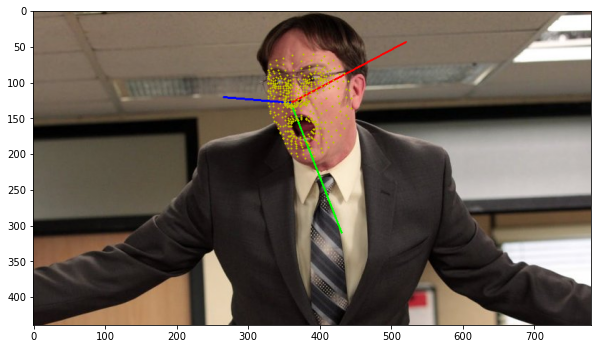

In [20]:
pitch, yaw, roll,x_y_list = predict_pyr('Dw.jpg')
print(pitch, yaw, roll)

plt.figure(figsize=(10,10))

img = cv2.imread('Dw.jpg')

img = draw_axis(img, pitch, yaw, roll, x_y_list[1][0], x_y_list[1][1], size = 200)
    
plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for pt in x_y_list:
#     print(pt)
    plt.scatter(pt[0],pt[1],c = 'y',s = 1);

#     plt.scatter(x_y_list[10][0],x_y_list[10][1],c = 'black',s = 5);

plt.imshow(plt_img);

[-0.19354321] [-0.34519284] [-0.18947798]


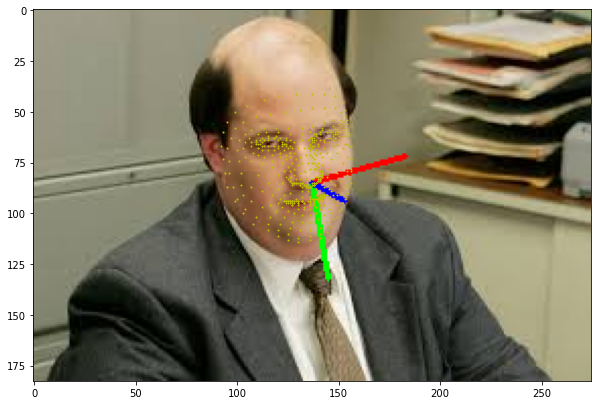

In [21]:
pitch1, yaw1, roll1,x_y_list = predict_pyr('Kv.jpg')
print(pitch1, yaw1, roll1)

plt.figure(figsize=(10,10))

img = cv2.imread('Kv.jpg')

img = draw_axis(img, pitch1, yaw1, roll1, x_y_list[1][0], x_y_list[1][1], size = 50)
    
plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for pt in x_y_list:
#     print(pt)
    plt.scatter(pt[0],pt[1],c = 'y',s = 1);

#     plt.scatter(x_y_list[10][0],x_y_list[10][1],c = 'black',s = 5);

plt.imshow(plt_img);

[-0.17018424] [-0.25383475] [0.11648841]


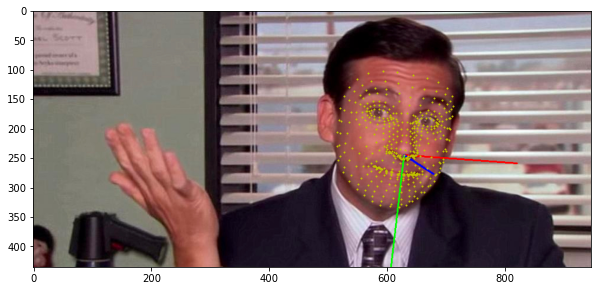

In [22]:
pitch, yaw, roll,x_y_list = predict_pyr('Ms.jpg')
print(pitch, yaw, roll)
plt.figure(figsize=(10,10))

img = cv2.imread('Ms.jpg')

img = draw_axis(img, pitch, yaw, roll, x_y_list[1][0], x_y_list[1][1], size = 200)
    
plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for pt in x_y_list:
#     print(pt)
    plt.scatter(pt[0],pt[1],c = 'y',s = 1);

#     plt.scatter(x_y_list[10][0],x_y_list[10][1],c = 'black',s = 5);

plt.imshow(plt_img);

[-0.09442685] [0.55500784] [-0.16761095]


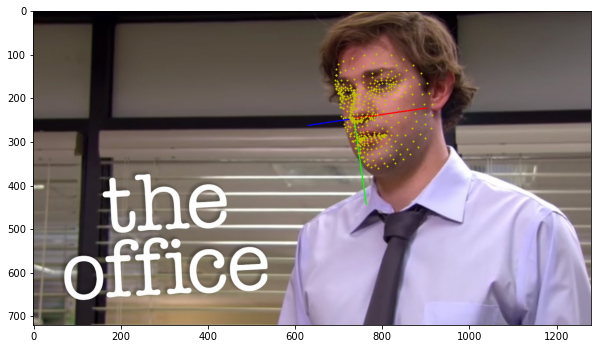

In [23]:
pitch3, yaw3, roll3,x_y_list = predict_pyr('Jh.jpg')
print(pitch3, yaw3, roll3)

plt.figure(figsize=(10,10))

img = cv2.imread('Jh.jpg')

img = draw_axis(img, pitch3, yaw3, roll3, x_y_list[1][0], x_y_list[1][1], size = 200)
    
plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for pt in x_y_list:
#     print(pt)
    plt.scatter(pt[0],pt[1],c = 'y',s = 1);

#     plt.scatter(x_y_list[10][0],x_y_list[10][1],c = 'black',s = 5);

plt.imshow(plt_img);

## Test on a video 

In [24]:
video_path = "Ms.mp4"
filename = 'MS_final.avi'

histoy_frames = 7

pitch_list = []
yaw_list = []
roll_list = []

cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
#     img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     print(frame)
    pitch, yaw, roll,x_y_list = predict_pyr(frame, frame=True)
#     print(frame)
    
#     img = cv2.imread(frame)
    if pitch == yaw == roll == 0:
        img = frame
    else:
        pitch_list.append(pitch)
        yaw_list.append(yaw)
        roll_list.append(roll)
        
        if len(pitch_list) >= histoy_frames:
            img = draw_axis(frame, np.mean(pitch_list[-1 *histoy_frames :]), np.mean(yaw_list[-1 *histoy_frames :]),
                            np.mean(roll_list[-1 *histoy_frames :]), x_y_list[1][0], x_y_list[1][1], size = 200)
        else:
            img = draw_axis(frame, pitch, yaw, roll, x_y_list[1][0], x_y_list[1][1], size = 200)

#     plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    out.write(img)
    
#     for pt in x_y_list:
#         #     print(pt)
#         plt.scatter(pt[0],pt[1],c = 'y',s = 1);
#     cv2.imshow('', plt_img)
    
#     cv2.imshow('frame', plt_img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
out.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
